## Model Evaluation & Validation
## Project: Predicting Boston Housing Prices

## Table of Contents

1. [Introduction](#1-bullet)
2. [Data Exploration](#2-bullet)
3. [Dveloping a Model](#3-bullet)
4. [Analyzing Model Performance](#4-bullet)
5. [Evaluating Model Performance](#5-bullet)

## 1. Introduction <a class="anchor" id="1-bullet"></a>

In this project, I evaluated the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

In [18]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print ("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


## 2. Data Exploration <a class="anchor" id="2-bullet"></a>

In this first section of this project, you will make a cursory investigation about the Boston housing data and provide your observations. Familiarizing yourself with the data through an explorative process is a fundamental practice to help you better understand and justify your results.

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Variable Information:

- RM: average number of rooms per dwelling 
- PTRATIO: pupil-teacher ratio by town 
- LSTAT: % lower status of the population 
- MEDV: Median value of owner-occupied homes in $1000's <= **target**

In [2]:
data.head()

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 4 columns):
RM         489 non-null float64
LSTAT      489 non-null float64
PTRATIO    489 non-null float64
MEDV       489 non-null float64
dtypes: float64(4)
memory usage: 15.4 KB


In [4]:
data.describe()

,RM,LSTAT,PTRATIO,MEDV
count,489.000000,489.000000,489.000000,4.890000e+02
mean,6.240288,12.939632,18.516564,4.543429e+05
std,0.643650,7.081990,2.111268,1.653403e+05
min,3.561000,1.980000,12.600000,1.050000e+05
25%,5.880000,7.370000,17.400000,3.507000e+05
50%,6.185000,11.690000,19.100000,4.389000e+05
75%,6.575000,17.120000,20.200000,5.187000e+05
max,8.398000,37.970000,22.000000,1.024800e+06


In [5]:
data.corr()

,RM,LSTAT,PTRATIO,MEDV
RM,1.000000,-0.612033,-0.304559,0.697209
LSTAT,-0.612033,1.000000,0.360445,-0.760670
PTRATIO,-0.304559,0.360445,1.000000,-0.519034
MEDV,0.697209,-0.760670,-0.519034,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000274B09AD908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000274B4EE2940>]], dtype=object)

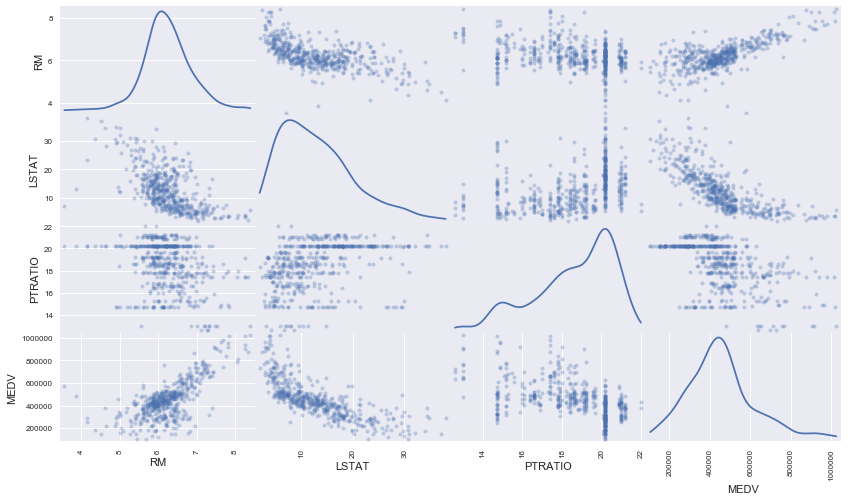

In [6]:
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde')

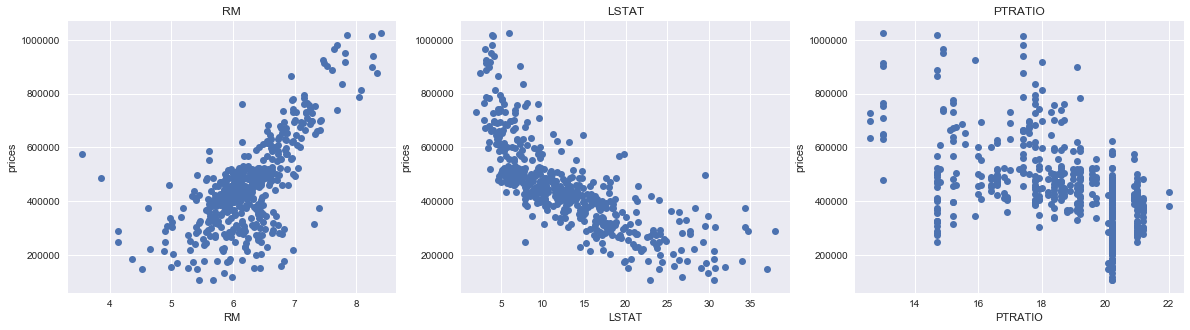

In [7]:
plt.figure(figsize=(20, 5))
for i, col in enumerate(features.columns):
    plt.subplot(1, 3, i+1)
    plt.plot(data[col], prices, 'o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('prices')

### Question 1 - Feature Observation

_Using your intuition, for each of the three features above, do you think that an increase in the value of that feature would lead to an **increase** in the value of `'MEDV'` or a **decrease** in the value of `'MEDV'`? Justify your answer for each._ 

**Answer: **

Setting my bivariate analysis charts above aside, my intuition is as followings:
- If RM increases in the value, MEDV increases as well. A number of rooms incidicates a size of a house which aligns with its price.
- If LSAT increases in the value, MEDV decreases because I assume "lower class" neighborhood indicates lower house price.
- If PTRATIO increases in the value, MDEV decreases. Expensive schools have lower PTRATIO and thus indicates "Upper class" neighborhood which has higher MDEV values.

----

## 3. Developing a Model <a class="anchor" id="3-bullet"></a>
In this second section of the project, you will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in your predictions.

### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, I will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify a model's performance. **The coefficient of determination for a model is a useful statistic in regression analysis**, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

For the `performance_metric` function in the code cell below, I implemented the following:
- Use `r2_score` from `sklearn.metrics` to perform a performance calculation between `y_true` and `y_predict`.
- Assign the performance score to the `score` variable.

In [8]:
# Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Question 2 - Goodness of Fit
Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |
*Would you consider this model to have successfully captured the variation of the target variable? Why or why not?* 

In [9]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print ("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.923.


**Answer:**

Yes, R2 score 0.923 indicates that this model explaines 92.3% of the target variables. This score is generally considered as high and the model is considered having successfully captured the variation of the target variable.

Aside from R2 score, the other possible options are mean squared error and mean absolute error to measure the model performance.

### Implementation: Shuffle and Split Data
Next implementation requires that I take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

For the code cell below, I implemented the following:
- Use `train_test_split` from `sklearn.cross_validation` to shuffle and split the `features` and `prices` data into training and testing sets.
  - Split the data into 80% training and 20% testing.
  - Set the `random_state` for `train_test_split` to a value of your choice. This ensures results are consistent.
- Assign the train and testing splits to `X_train`, `X_test`, `y_train`, and `y_test`.

In [10]:
# Import 'train_test_split'
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(
features, prices, test_size=0.2, random_state=8)

# Success
print ("Training and testing split was successful.")

Training and testing split was successful.


### Question 3 - Training and Testing
*What is the benefit to splitting a dataset into some ratio of training and testing subsets for a learning algorithm?*

**Answer: **

A training set is used to train a model and a testing set is used to test the model's performance on unseeen data. Without having train and test data separately, you risk overfitting a model by fitting a model to all the data you have and you don't have a way to test performance of the model.

The benefit of splitting Boston Housing Data into training and testing data would provide two independent dataset to

- Give estimate of performance on an independent dataset
- Serve as check on overfitting

Without the testing data, you will not gain insights about how your model is performing and will not allow you to work out issues like bias vs variance trade-offs.

----

## 4. Analyzing Model Performance <a class="anchor" id="4-bullet"></a>

In this third section of the project, I took a look at several models' learning and testing performances on various subsets of training data. Additionally, I investigated one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

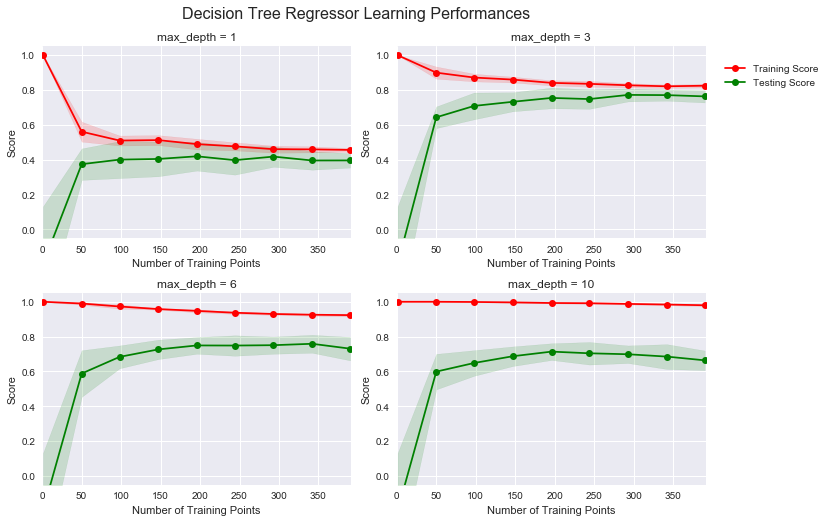

In [11]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Question 4 - Learning the Data
*Choose one of the graphs above and state the maximum depth for the model. What happens to the score of the training curve as more training points are added? What about the testing curve? Would having more training points benefit the model?*

**Answer: **

To give more context before looking at specific graph, when the training set is small, the trained model can essentially "memorize" all of the training data.  Thus training score in all the charts with fewer number training points is close to 1.0. This is called overfitting. As the training set gets larger, the model won't be able to fit all of the training data excatly, thus it results in lower score.

The oppositie is happenining with the test set. When the training set is small, then it's more likely the model hasn't see nsimilar data before. Thus lower score. As the training set gets larger, it becomes more likley that the model has seen similar data before, thus higher score.

On the graph with max_depth = 3, the training score continues to decline to 0.8 score and then plateau. Adding more than 300 training points doesn't improve the training score. The testing score continues to improve to 0.8 score and then flatten. From that point, adding more training points doesn't improve the score. Overall, adding training points certainly improves both training score and testing score until the scores converge to score 0.8.

The learning curves are very useful in making decisions on whether we collect new data to improve a model. In practice, collecting more data can often be time consuming and/or expensive. It is critical to understand the cost of collecting new data justifies the expected improvement of the model.

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.

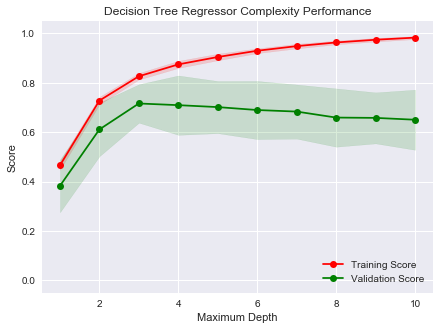

In [12]:
vs.ModelComplexity(X_train, y_train)

### Question 5 - Bias-Variance Tradeoff
*When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? What visual cues in the graph justify your conclusions?*

**Answer: **

With a maximum depth of 1, the model suffer from high bias. This is clear from the chart showing lower scores for both training score and validateion score. The poor scores indicate underfitting the data. Also note that it has low variance since the scores are close together. This model is not complex enough to learn the structure of the data.

In contrast, the model suffer from high variance with a maximum depth of 10. While the validation score plateues around 0.7, the traiing score improves as the model complexily increases(as maximum depth increases). This leads to a large gap between the training and validation scores. The model is just memorizing the training data and will not generalize well to new unseen data. In other words, the model is overfitting to the training data.

### Question 6 - Best-Guess Optimal Model
*Which maximum depth do you think results in a model that best generalizes to unseen data? What intuition lead you to this answer?*

**Answer: **

Maximum depth 4 looks best because validation score hit the maximum score and the gap between the training score and validation score is reasonably small.

-----

## 5. Evaluating Model Performance <a class="anchor" id="5-bullet"></a>

In this final section of the project, I constructed a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Question 7 - Grid Search
*What is the grid search technique and how it can be applied to optimize a learning algorithm?*

**Answer: **

Grid search automates hyperparameter tuning and saves time for manual tuning. It works by tuning the model with multiple combinations of hyperparameters and indentifying them that perform best. To identify the best performance, a grid algorithm must be guided by some performance metric.

Also note that grid search is an exhausive searching through a manually specified subset of the hyperparamters of a learning algorithm.

Bottom line: fine tuning a learning algorithm is important for a more successful learning/testing performance.

### Question 8 - Cross-Validation
*What is the k-fold cross-validation training technique? What benefit does this technique provide for grid search when optimizing a model?*  
**Hint:** Much like the reasoning behind having a testing set, what could go wrong with using grid search without a cross-validated set?

**Answer: **

k-fold cv is a technique to split data into k-subsets and to uses one subset to test the model and the rest of the data to train the model. Since there are k-substes, this set of train and test is conducted k times. The k results from the folds can then be averaged to produce a single estimation. This is extremely useful when the dataset is limited in size as Grid Search will allow an extensive exploitation of available data.

Cross validation is useful because it maximize both the training and testing data so that the data we can use to provide best learning result and best validation. This is very useful especially when the dataset is limited in size.

k-fold cv enables grid search finds best parameter not only for single validation set but for best parameter for genelaized case. This prevents grid search overfitting to a specific validation set.

### Implementation: Fitting a Model
Final implementation requires that I bring everything together and train a model using the **decision tree algorithm**. To ensure that I am producing an optimized model, I will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In addition, I will find your implementation is using `ShuffleSplit()` for an alternative form of cross-validation (see the `'cv_sets'` variable). While it is not the K-Fold cross-validation technique you describe in **Question 8**, this type of cross-validation technique is just as useful!. The `ShuffleSplit()` implementation below will create 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*. While you're working on your implementation, think about the contrasts and similarities it has to the K-fold cross-validation technique.

Please note that ShuffleSplit has different parameters in scikit-learn versions 0.17 and 0.18.
For the `fit_model` function in the code cell below, I will implement the following:
- Use [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) from `sklearn.tree` to create a decision tree regressor object.
  - Assign this object to the `'regressor'` variable.
- Create a dictionary for `'max_depth'` with the values from 1 to 10, and assign this to the `'params'` variable.
- Use [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) from `sklearn.metrics` to create a scoring function object.
  - Pass the `performance_metric` function as a parameter to the object.
  - Assign this scoring function to the `'scoring_fnc'` variable.
- Use [`GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) from `sklearn.grid_search` to create a grid search object.
  - Pass the variables `'regressor'`, `'params'`, `'scoring_fnc'`, and `'cv_sets'` as parameters to the object. 
  - Assign the `GridSearchCV` object to the `'grid'` variable.

In [13]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': [x for x in range(1, 11)]}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(estimator = regressor,
                        param_grid = params,
                        scoring = scoring_fnc,
                        cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. You can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

### Question 9 - Optimal Model
_What maximum depth does the optimal model have? How does this result compare to your guess in **Question 6**?_

In [14]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print ("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 3 for the optimal model.


**Answer: **

The optimal 'max_depth' value given by grid search is consistent with our guess in Question 6.

### Question 10 - Predicting Selling Prices
Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |
*What price would you recommend each client sell his/her home at? Do these prices seem reasonable given the values for the respective features?*  
**Hint:** Use the statistics you calculated in the **Data Exploration** section to help justify your response.

In [15]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print ("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $351,577.61
Predicted selling price for Client 2's home: $243,857.89
Predicted selling price for Client 3's home: $904,718.18


In [16]:
features.describe()

,RM,LSTAT,PTRATIO
count,489.000000,489.000000,489.000000
mean,6.240288,12.939632,18.516564
std,0.643650,7.081990,2.111268
min,3.561000,1.980000,12.600000
25%,5.880000,7.370000,17.400000
50%,6.185000,11.690000,19.100000
75%,6.575000,17.120000,20.200000
max,8.398000,37.970000,22.000000


**Answer: **

As for the predictions,
- For Clinet 1's house with 'RM'=5, 'LSTAT'=17 and 'PTRATIO'=15, the house prices approximately fall in a range of \$180000 - 500000. The predicted price is \$391,183.33 which falls nicely around the middle of the range.
- For Clinet 2's house with 'RM'=4, 'LSTAT'=32 and 'PTRATIO'=22, the house prices approximately fall in a range of \$180000 - 420000. The predicted price is \$189,123.53 which falls around bottom limit of the range.
- For Clinet 3's house with 'RM'=8, 'LSTAT'=3 and 'PTRATIO'=12, the house prices approximately fall in a range of \$500000 - 1200000. The predicted price is \$942,666.67 which falls nicely around the middle of the range. 

As for features,
- All values given for each feature fall into a range of min-max for each feature in the training data set. Thus, these features are considered reasonable.

### Sensitivity
**An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data.** Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. Run the code cell below to run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with the data it's trained on.

In [17]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $419,700.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $418,377.27
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $69,044.61


### Question 11 - Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

**Answer: **
This model should not be used in real-world setting considering that:
1. The dateset was collected in 1978 and might be irrelevant for current real estitate market. LSAT, PTRATIO, RM and MDEV have changed over the last 39 years. The datasets must be updated to accurately predict the housing price. 
2. Additional features such as crime rate, distance to universities, remodelling activities, age of the homes etc should be explored and utilized for better describing a home as they might influence the price of the home.
3. Differences between rural market and urban market should be considered in the model. Intuitively, these two markets have their unique characteristics. E.g. A house in a rural city has more rooms and space.